# Advanced Models

Models beyond logistic regression.

## Imports and Functions

In [ ]:
import pickle

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer

# prep for models and search parameter space
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline


# models
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, 
    classification_report, 
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score,
)

### Functions

In [2]:
def evaluate_model(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                   short_name='short', return_misclassified=False, return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = "Model details here"
        string to form the subtitle of figures
    short_name : str, default = "short"
        string used name saved figures and scoring dictionary
    return_misclassified : bool, default = False
        returns Data Frame of misclassified results when True: true value, predicted value, probability calculated by model
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res : pandas Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for misclassified results, only returned if `return_misclassified == True`
    res_all : panda Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)

    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }
    
    # misclassified results
    results = []
    for i in range(len(y_test)):
        if preds[i] != y_test.iloc[i]:
            results.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})

    res = pd.DataFrame(results)

    # probability histogram of misclassified results
    fig_hist = px.histogram(
        res, 
        x='prob_fraud', 
        title = 'Probability Distribution of Misclassified Job Ads', 
        subtitle= f'Model: {fig_subtitle}'
    )

    fig_hist.show()


    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');

    # save figures, if save_figs is True
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_hist.write_image(f'../images/hist_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    # return options
    if return_all_results == True and return_misclassified == True:
        return scores, res, res_all
    elif return_all_results == True:
        return scores, res_all
    elif return_misclassified == True:
        return scores, res
    else:
        return scores

In [3]:
def evaluate_model_noprob(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                          short_name='short', return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = 'Model details here'
        string to form the subtitle of figures
    short_name : str, default = 'short'
        string used name saved figures
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res_all : panda Data Frame, optional
        contains the true and predicted values for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    
    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }

    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');
    
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    if return_all_results == True:
        return scores, res_all
    else:
        return scores

In [4]:
def save_model (model, filename):
    '''
    pickles model as filename.pkl in the models directory
    '''
    with open(f'./models/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)

### Functions to Style Tables

In [5]:
def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

In [6]:
def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

## Data

### Data Import

In [7]:
df = pd.read_csv('../data/clean/job_ads.csv')

In [8]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,job_ad
0,0,1,0,Other,Internship,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,Full-time,Not Applicable,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,NaN,NaN,0,Valor Services provides Workforce Solutions th...
3,0,1,0,Full-time,Mid-Senior level,0,Our passion for improving quality of life thro...
4,0,1,1,Full-time,Mid-Senior level,0,SpotSource Solutions LLC is a Global Human Cap...


### Set Up Data

In [9]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

In [10]:
X = X.fillna('')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)

In [12]:
X_train.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'job_ad'],
      dtype='object')

In [13]:
type(X_test)

pandas.core.frame.DataFrame

In [14]:
X_test.shape

(4470, 6)

## Random Forest Models

In [68]:
model_random_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('forest', RandomForestClassifier(n_estimators=500, max_depth=10, max_features='sqrt', ))
])

In [70]:
random_params = {
    'forest__n_estimators': [500],
    'forest__max_features': ['sqrt', 1.0, 0.5],
    'forest__max_depth': [10, 20],
    'forest__min_samples_split': [3,10],
}

In [73]:
grid_forest = GridSearchCV(model_random_cv, param_grid=random_params, scoring='f1')

In [74]:
grid_forest.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('forest',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=500))]),
             param_grid={'forest__max_depth': [10, 20],
                         'forest__max_features': ['sqrt', 1.0, 0.5],
                         'forest__min_samples_split': [3, 10],
                         'forest__n_estimators': [500]},
             scoring='f1')

In [75]:
grid_forest.best_score_
grid_forest.best_params_

{'forest__max_depth': 20,
 'forest__max_features': 1.0,
 'forest__min_samples_split': 3,
 'forest__n_estimators': 500}


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.95      0.69      0.80       216

    accuracy                           0.98      4470
   macro avg       0.97      0.84      0.89      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



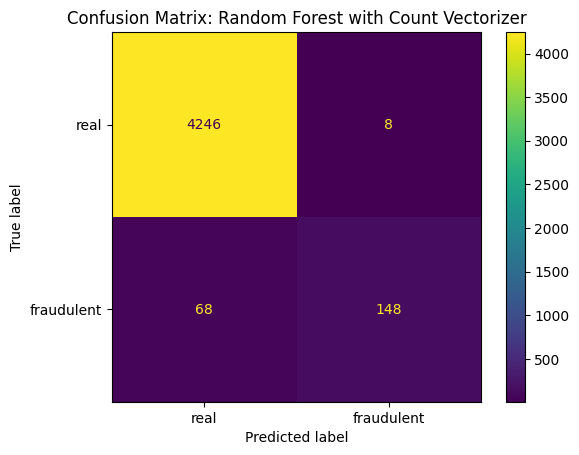

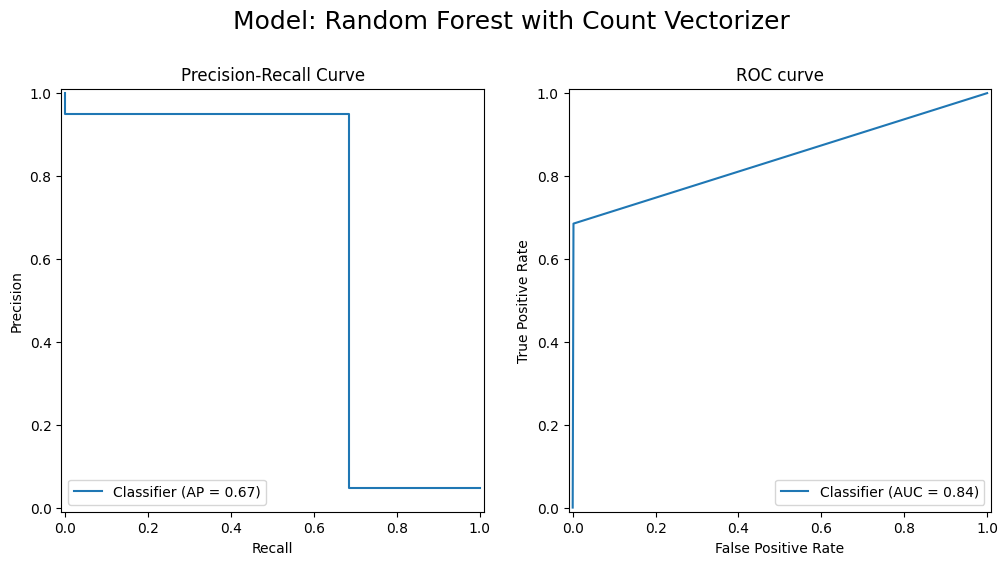

In [76]:
scores_best_random_cv, res_best_random_cv = evaluate_model(
    grid_forest, X_test, y_test, 
    fig_subtitle= 'Random Forest with Count Vectorizer', 
    short_name='random_cv_best', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [77]:
save_model(grid_forest, 'model_random_cv_best')

In [78]:
res_best_random_cv.to_csv('../data/results/res_random_cv_best.csv')

In [79]:
scores_best_random_cv

{'model': 'random_cv_best',
 'accuracy': 0.9829977628635347,
 'precision': 0.9487179487179487,
 'recall': 0.6851851851851852,
 'f1_score': 0.7956989247311828,
 'roc_auc_score': 0.8416523011022305}

## Naive Bayes

### Multinomial Naive Bayes Models

#### Count Vectorizer

In [15]:
model_bayes_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', MultinomialNB())
])

In [16]:
model_bayes_cv.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('cvec', CountVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('bayes', MultinomialNB())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('cvec', CountVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'bayes': MultinomialNB(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_w

In [17]:
grid_multi_bayes = GridSearchCV(
    model_bayes_cv,
    param_grid = {'bayes__alpha': [0.5, 1, 2, 5]},
    scoring='f1'
)

In [18]:
grid_multi_bayes.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cvec',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('bayes', MultinomialNB())]),
             param_grid={'bayes__alpha': [0.5, 1, 2, 5]}, scoring='f1')

In [20]:
grid_multi_bayes.best_params_

{'bayes__alpha': 0.5}

/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/1519898396.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cm.show()



Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.95      0.68      0.79       216

    accuracy                           0.98      4470
   macro avg       0.97      0.84      0.89      4470
weighted avg       0.98      0.98      0.98      4470



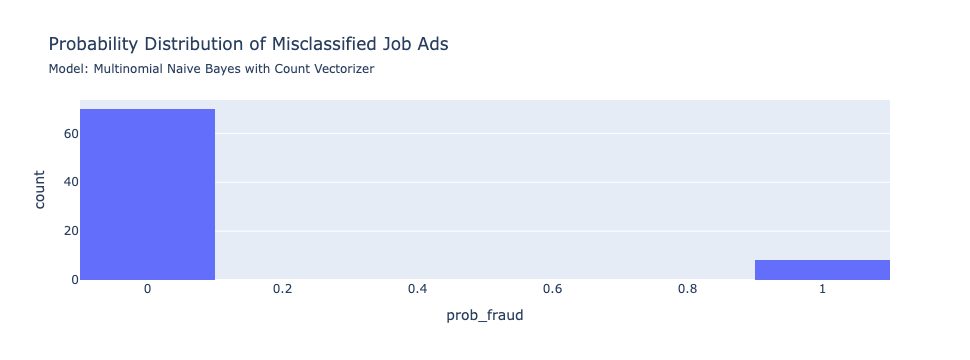

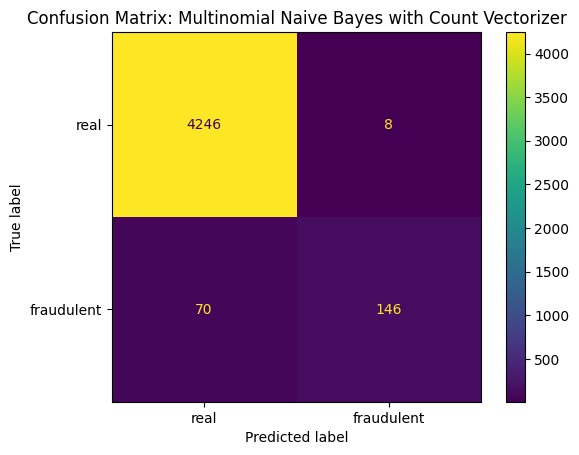

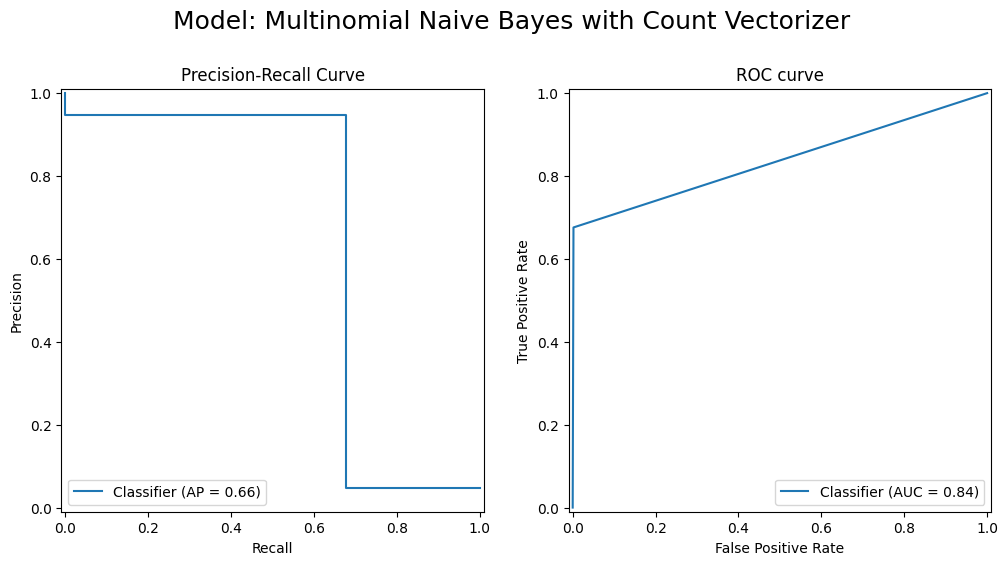

In [21]:
scores_cv_bayes, res_cv_bayes = evaluate_model(
    grid_multi_bayes, X_test, y_test, 
    fig_subtitle= 'Multinomial Naive Bayes with Count Vectorizer', 
    short_name='cv_bayes', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [22]:
save_model(grid_multi_bayes, 'model_bayes_cv_best')

In [23]:
res_cv_bayes.to_csv('../data/results/res_cv_bayes_best.csv')

In [24]:
scores_cv_bayes

{'model': 'cv_bayes',
 'accuracy': 0.9825503355704698,
 'precision': 0.948051948051948,
 'recall': 0.6759259259259259,
 'f1_score': 0.7891891891891892,
 'roc_auc_score': 0.837022671472601}

### Complement Naive Bayes

#### Count Vectorizer

In [25]:
model_comp_bayes_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('bayes', ComplementNB())
])

In [27]:
grid_comp_bayes_cv = GridSearchCV(
    model_comp_bayes_cv,
    param_grid = {'bayes__alpha': [0.5, 1, 2, 5]},
    scoring= 'f1',
)

In [28]:
grid_comp_bayes_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cvec',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('bayes', ComplementNB())]),
             param_grid={'bayes__alpha': [0.5, 1, 2, 5]}, scoring='f1')


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.94      0.68      0.78       216

    accuracy                           0.98      4470
   macro avg       0.96      0.84      0.89      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



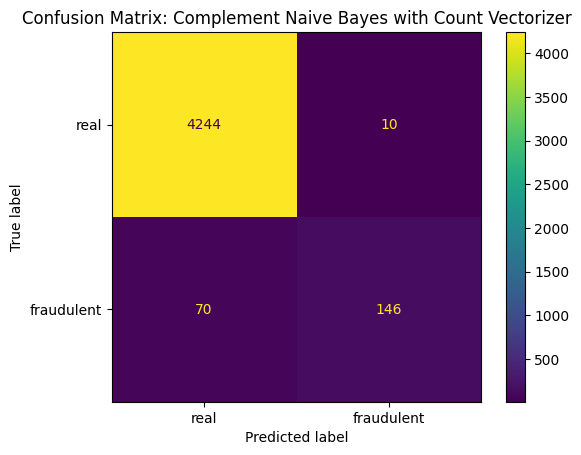

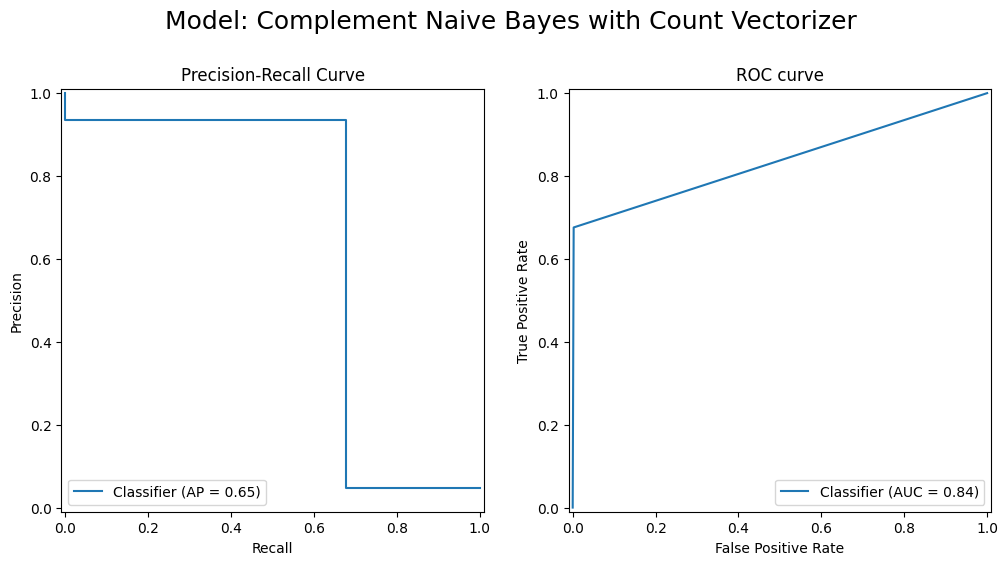

In [29]:
scores_comp_bayes_cv, res_comp_bayes_cv = evaluate_model(
    grid_comp_bayes_cv, X_test, y_test, 
    fig_subtitle= 'Complement Naive Bayes with Count Vectorizer', 
    short_name='comp_bayes_cv_best', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [30]:
save_model(grid_comp_bayes_cv, 'model_comp_bayes_cv_best')

In [31]:
res_comp_bayes_cv.to_csv('../data/results/res_comp_bayes_cv_best.csv')

In [32]:
scores_comp_bayes_cv

{'model': 'comp_bayes_cv_best',
 'accuracy': 0.9821029082774049,
 'precision': 0.9358974358974359,
 'recall': 0.6759259259259259,
 'f1_score': 0.7849462365591398,
 'roc_auc_score': 0.8367875986000105}

## Support Vector Machine (SVM) Models

Support Vector Machine (SVM) models use a function, known as a kernel, to project the data into a higher dimensional space, draws a hyperplane to separate the classes and then returns to the original parameter space.  Sadly, this separating hyperplane is _not_ guaranteed to exist.  If it does not exist, then support vector classifiers (SVC) use a _soft margin_ to find the hyperplane that works best for most of the data points.  "Soft" means that there will be a few data points on the wrong side of the hyperplane, but the model works to keep these data points as close to the hyperplane as possible.

#### SVC with Count Vectorizer

In [33]:
model_svc_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('svc', LinearSVC())
])

By default, the linear SVC model employs $\ell_2$ penalty (Ridge regularization) and uses a squared hinge loss function.

In [35]:
Cs = np.logspace(-8,4,11)

In [36]:
Cs

array([1.00000000e-08, 1.58489319e-07, 2.51188643e-06, 3.98107171e-05,
       6.30957344e-04, 1.00000000e-02, 1.58489319e-01, 2.51188643e+00,
       3.98107171e+01, 6.30957344e+02, 1.00000000e+04])

In [38]:
model_svc_cv.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('svc', LinearSVC())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'svc': LinearSVC(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 

In [55]:
params_svc = {
    'svc__C': Cs,
    'svc__max_iter': [5000]
}

In [56]:
grid_svc = GridSearchCV(model_svc_cv, param_grid= params_svc, scoring='f1')

In [60]:
grid_svc.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning:

Liblinear failed

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('svc', LinearSVC())]),
             param_grid={'svc__C': array([1.00000000e-08, 1.58489319e-07, 2.51188643e-06, 3.98107171e-05,
       6.30957344e-04, 1.00000000e-02, 1.58489319e-01, 2.51188643e+00,
       3.98107171e+01, 6.30957344e+02, 1.00000000e+04]),
                         'svc__max_iter': [5000]},
             scoring='f1')

In [61]:
grid_svc.best_params_

{'svc__C': 0.01, 'svc__max_iter': 5000}

In [62]:
grid_svc.best_score_

0.8235026474762304


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.96      0.74      0.84       216

    accuracy                           0.99      4470
   macro avg       0.97      0.87      0.91      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/2419598850.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



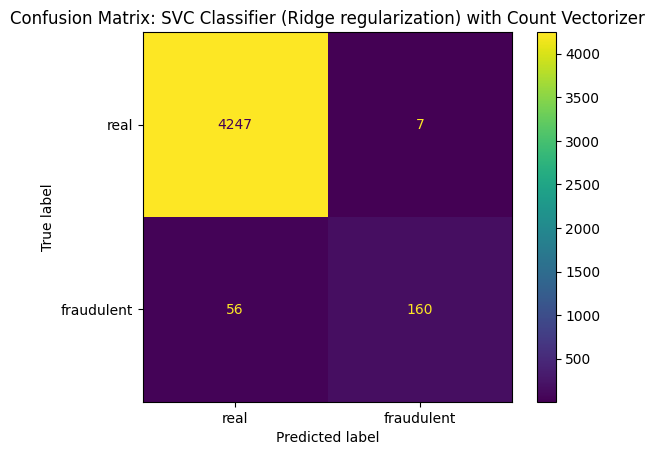

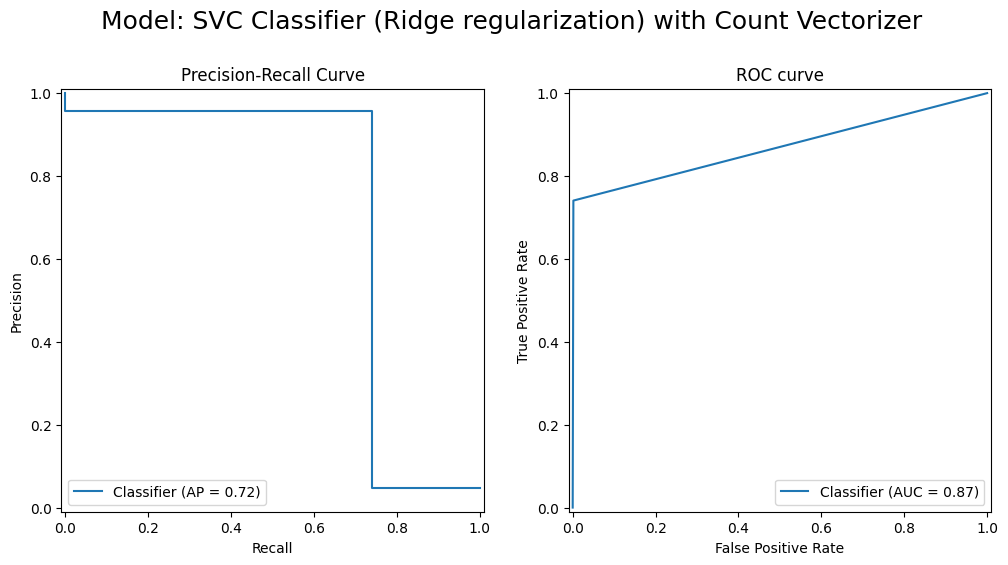

In [63]:
scores_svc_cv, res_svc_cv = evaluate_model_noprob(
    grid_svc, X_test, y_test, 
    fig_subtitle= 'SVC Classifier (Ridge regularization) with Count Vectorizer', 
    short_name='svc_cv_ridge', 
    save_figs=True,
    return_all_results = True
)

In [64]:
save_model(grid_svc, 'grid_svc_cv')

In [65]:
res_svc_cv.to_csv('../data/results/res_svc_cv.csv')

In [66]:
scores_svc_cv

{'model': 'svc_cv_ridge',
 'accuracy': 0.9859060402684564,
 'precision': 0.9580838323353293,
 'recall': 0.7407407407407407,
 'f1_score': 0.835509138381201,
 'roc_auc_score': 0.8695476153163036}

## Stochastic Gradient Descent (SGD) Classifiers

comments

In [44]:
model_sgd_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('sgd', SGDClassifier())
])

In [45]:
model_sgd_cv.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('sgd', SGDClassifier())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'sgd': SGDClassifier(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights':

In [46]:
sgd_params = {
    'sgd__alpha': [1e-5, 1e-4, 1e-3],
    'sgd__loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
    'sgd__max_iter': [2000]
}

In [47]:
grid_sgd_cv = GridSearchCV(
    model_sgd_cv,
    param_grid = sgd_params,
    scoring='f1',
)

In [48]:
grid_sgd_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('sgd', SGDClassifier())]),
             param_grid={'sgd__alpha': [1e-05, 0.0001, 0.001],
                         'sgd__loss': ['hinge', 'modified_huber',
                                       'squared_hinge', 'perceptron'],
                         'sgd__max_iter': [2000]},
             scoring='f1')

In [49]:
grid_sgd_cv.best_params_

{'sgd__alpha': 1e-05, 'sgd__loss': 'hinge', 'sgd__max_iter': 2000}


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.85      0.79      0.82       216

    accuracy                           0.98      4470
   macro avg       0.92      0.89      0.91      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/2419598850.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



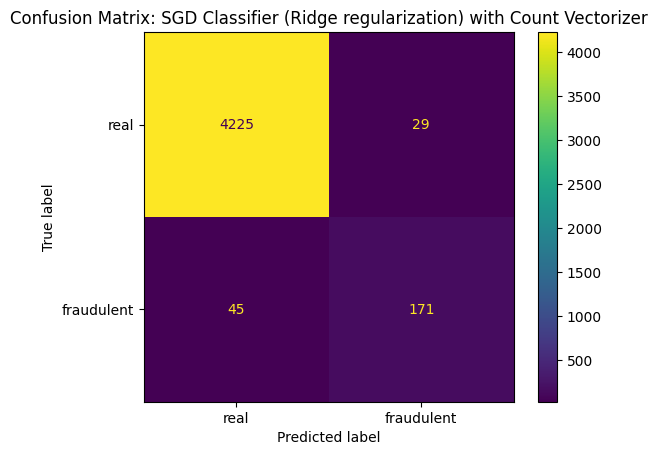

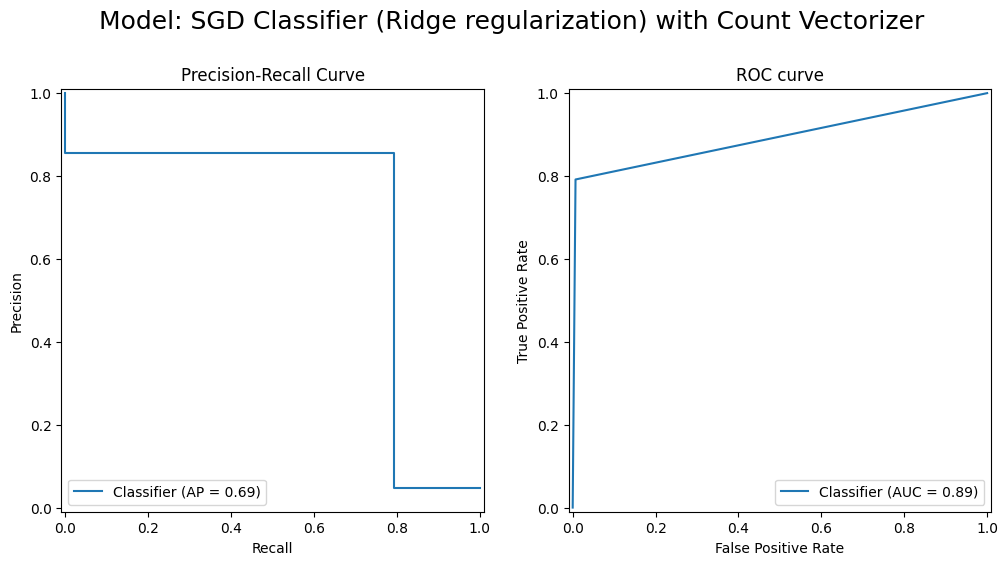

In [50]:
scores_sgd_cv, res_sgd_cv = evaluate_model_noprob(
    grid_sgd_cv, X_test, y_test, 
    fig_subtitle= 'SGD Classifier (Ridge regularization) with Count Vectorizer', 
    short_name='sgd_cv_ridge', 
    save_figs=True,
    return_all_results = True
)

In [51]:
save_model(model_sgd_cv, 'model_sgd_cv')

In [52]:
res_sgd_cv.to_csv('../data/results/res_sgd_cv.csv')

In [53]:
scores_sgd_cv

{'model': 'sgd_cv_ridge',
 'accuracy': 0.9834451901565996,
 'precision': 0.855,
 'recall': 0.7916666666666666,
 'f1_score': 0.8221153846153846,
 'roc_auc_score': 0.892424776680771}

## KNeighbors Classifier

#### Model

In [84]:
model_kn_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('kn', KNeighborsClassifier())
])

In [85]:
model_kn_cv.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('kn', KNeighborsClassifier())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'kn': KNeighborsClassifier(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transform

In [86]:
kn_params = {
    #'ct__cv__stop_words': [None, 'english']
    'kn__weights': ['uniform', 'distance'],
    'kn__n_neighbors': [4,5,10,15]
}

In [87]:
grid_kn = GridSearchCV(
    model_kn_cv,
    param_grid = kn_params,
    scoring= 'f1',
)

In [88]:
grid_kn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('kn', KNeighborsClassifier())]),
             param_grid={'kn__n_neighbors': [4, 5, 10, 15],
                         'kn__weights': ['uniform', 'distance']},
             scoring='f1')

In [89]:
grid_kn.best_params_

{'kn__n_neighbors': 5, 'kn__weights': 'distance'}


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      0.99      0.99      4254
  fraudulent       0.74      0.69      0.72       216

    accuracy                           0.97      4470
   macro avg       0.86      0.84      0.85      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_93646/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



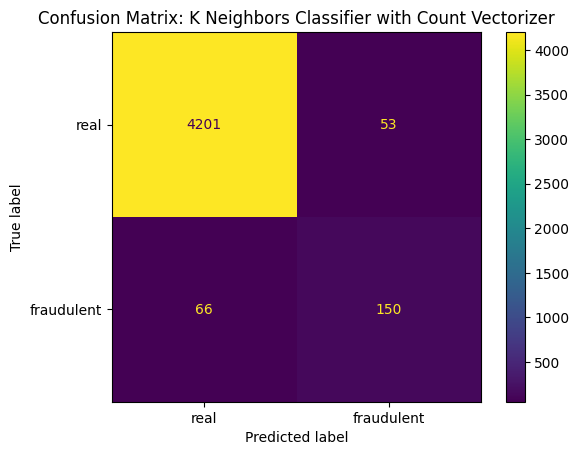

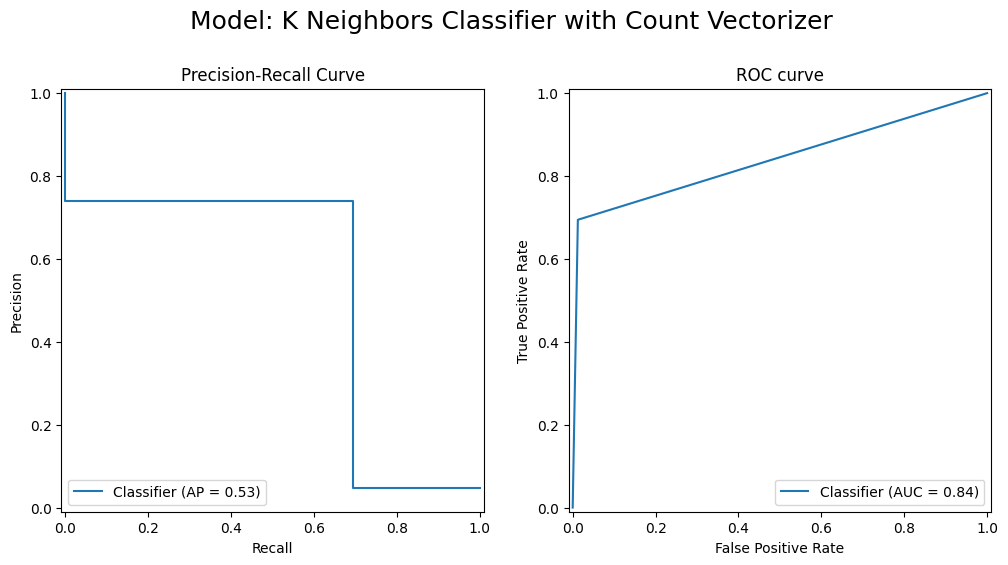

In [90]:
scores_kn_cv, res_kn_cv = evaluate_model(
    grid_kn, X_test, y_test, 
    fig_subtitle= 'K Neighbors Classifier with Count Vectorizer', 
    short_name='kn_cv', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [91]:
save_model(grid_kn, 'model_kn_cv')

In [92]:
res_kn_cv.to_csv('../data/results/res_kn_cv.csv')

In [93]:
scores_kn_cv

{'model': 'kn_cv',
 'accuracy': 0.9733780760626398,
 'precision': 0.7389162561576355,
 'recall': 0.6944444444444444,
 'f1_score': 0.7159904534606205,
 'roc_auc_score': 0.8409927910985738}

## Summary

In [94]:
all_scores = [
    #scores_log_cv, 
    scores_best_random_cv,
    scores_cv_bayes,
    scores_comp_bayes_cv,
    scores_svc_cv,
    scores_sgd_cv,
    scores_kn_cv
]

In [95]:
all_scores_df = pd.DataFrame(all_scores)

In [96]:
all_scores_df.to_csv('./models/adv_scores.csv', index=False)

In [97]:
#all_scores_df = pd.read_csv('./models/adv_scores.csv')#.drop(columns=['Unnamed: 0'])

In [98]:
#all_scores_df = pd.concat([scores_base, all_scores_df], ignore_index=True, axis=0)

In [99]:
#all_scores_df

In [101]:
all_scores_df.style.apply(highlight_max, props='color:white;background-color:darkblue', 
                          axis=0, subset=['accuracy','precision','recall', 'f1_score','roc_auc_score'])

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,random_cv_best,0.982998,0.948718,0.685185,0.795699,0.841652
1,cv_bayes,0.982550,0.948052,0.675926,0.789189,0.837023
2,comp_bayes_cv_best,0.982103,0.935897,0.675926,0.784946,0.836788
3,svc_cv_ridge,0.985906,0.958084,0.740741,0.835509,0.869548
4,sgd_cv_ridge,0.983445,0.855000,0.791667,0.822115,0.892425
5,kn_cv,0.973378,0.738916,0.694444,0.715990,0.840993


The best advanced model is the SVC model with ridge classification.  Let's take this information with us to the [final notebook](4_summary.ipynb) where we bring all of the pieces together.  